实验内容
人口统计分析
国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。
城市级别分布：分析主要城市的开发者密度，发现技术热点区域。
时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。
协作行为分析
提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。
其他维度有趣的洞察（至少2个）
提交内容
数据分析代码。
最终的数据洞察报告（PDF格式）。


数据加载成功！
   user_id    name     location  total_influence        country   event_type  \
0   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
1   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
2   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
3   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
4   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   

  event_action                 event_time  
0        added  2024-11-26 20:28:37+08:00  
1        added  2024-11-26 20:42:57+08:00  
2        added  2024-11-27 04:10:46+08:00  
3        added  2024-11-27 17:43:50+08:00  
4        added  2024-11-27 19:56:34+08:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294776 entries, 0 to 1294775
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_id          1294776 non-null 

C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')


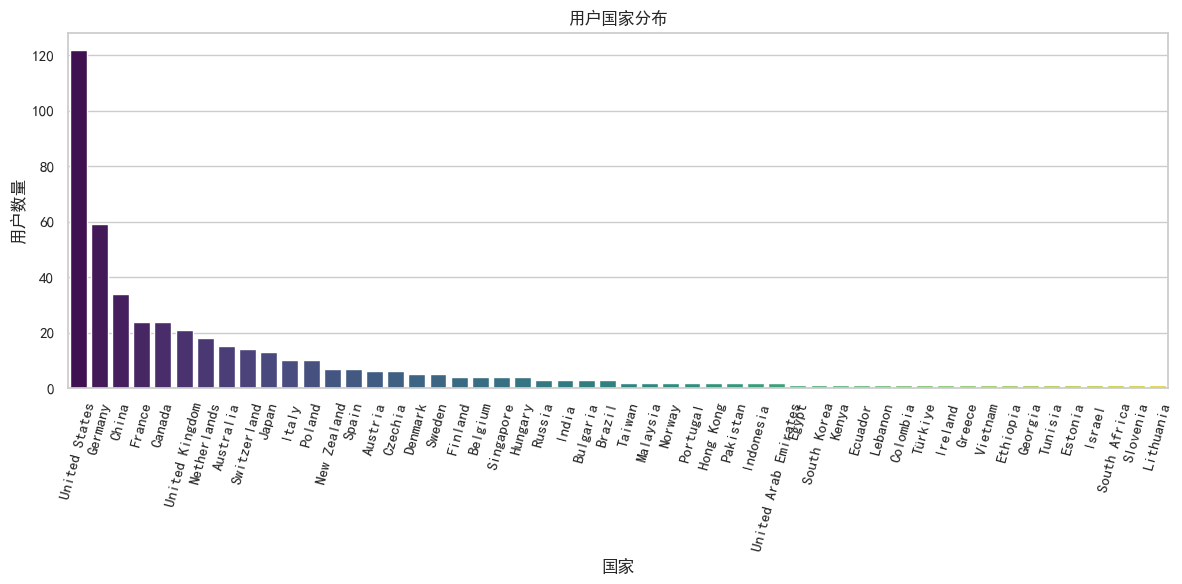

C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')


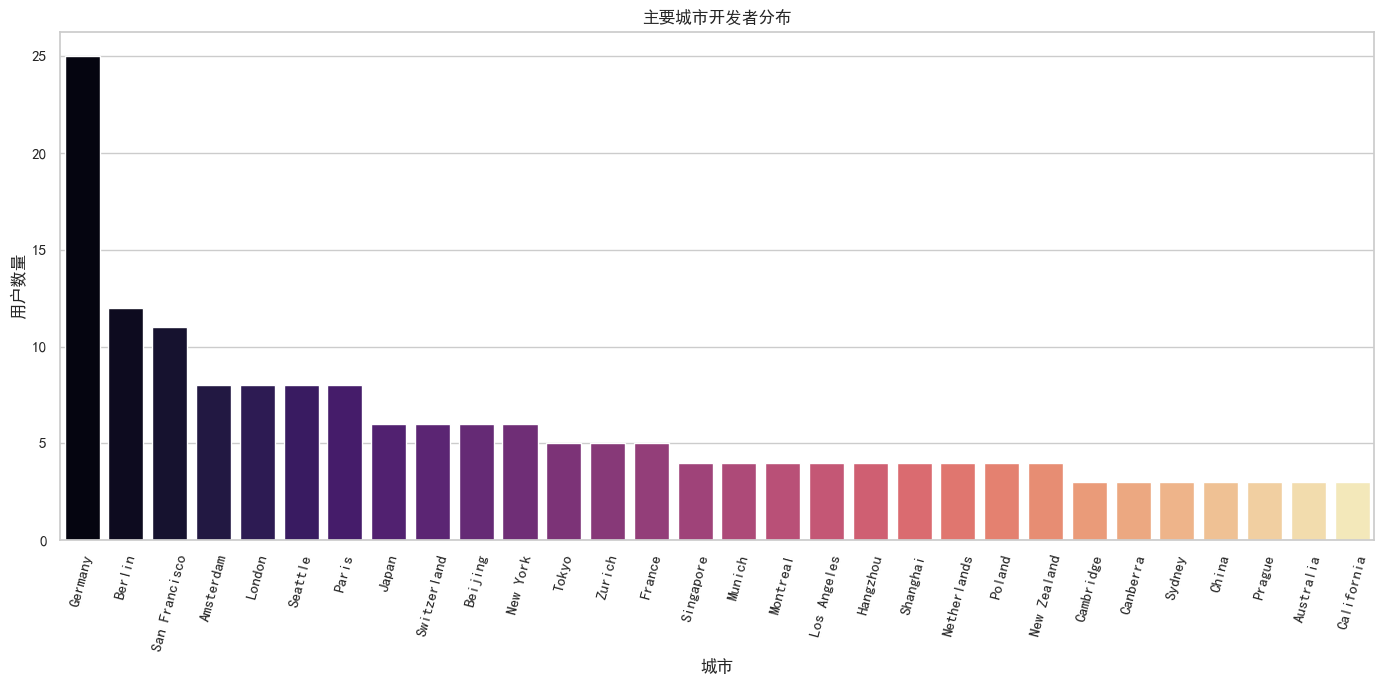

Timezone
Europe/Berlin          59
America/Los_Angeles    54
Asia/Shanghai          34
America/New_York       33
Europe/Paris           28
                       ..
Europe/Tallinn          1
Asia/Jerusalem          1
Africa/Johannesburg     1
Europe/Ljubljana        1
Europe/Vilnius          1
Name: count, Length: 67, dtype: int64


C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=timezone_counts.index, y=timezone_counts.values, palette='coolwarm')
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:219: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:219: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:219: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:219: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) Ar

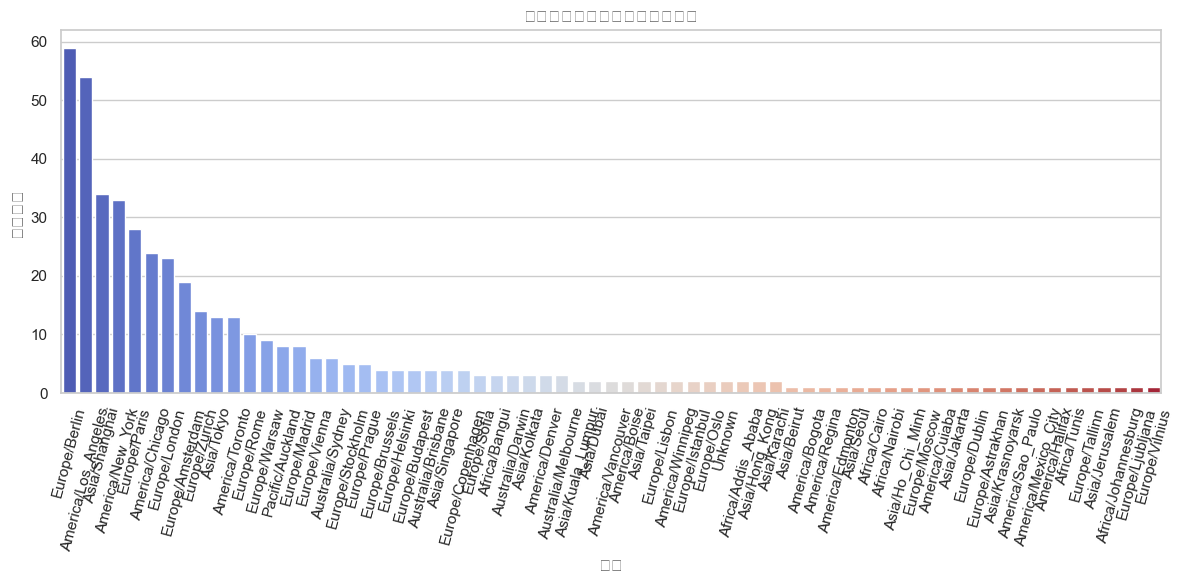

C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:230: UserWarning: Glyph 25552 (\N{CJK UNIFIED IDEOGRAPH-63D0}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:230: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:230: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:230: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:230: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:230: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing fro

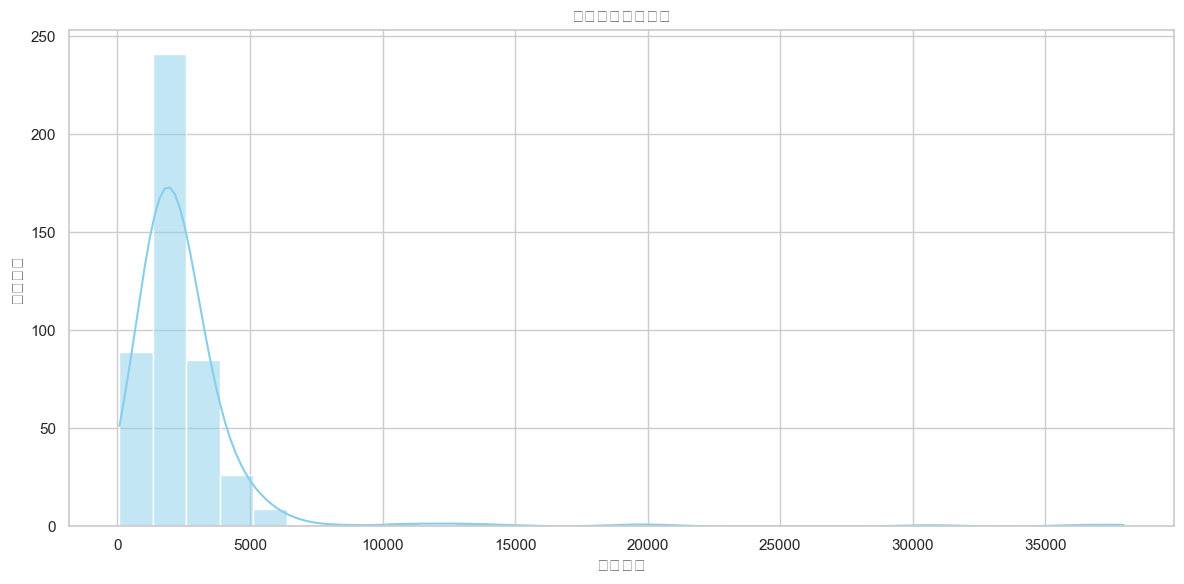

高活跃用户数量（提交次数 >= 2524.7）：139
低活跃用户数量（提交次数 <= 1596.5）：139


C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:252: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:252: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:252: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:252: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:252: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:252: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing fro

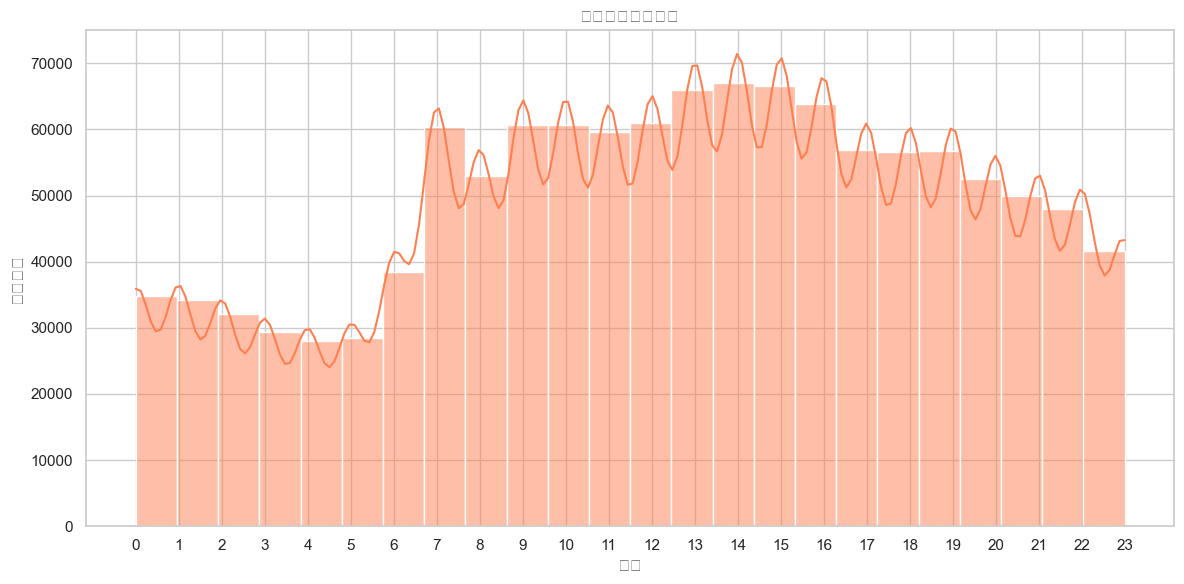

C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:259: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_type_counts.index, y=event_type_counts.values, palette='Set2')
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:264: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:264: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:264: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:264: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Ar

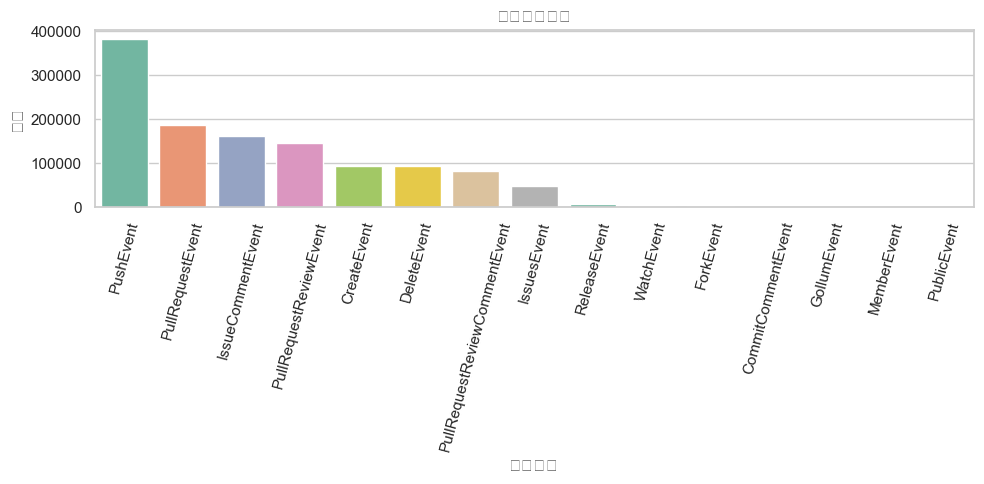

C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:270: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_action_counts.index, y=event_action_counts.values, palette='Set3')
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:275: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:275: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:275: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\大头\AppData\Local\Temp\ipykernel_24188\1155867147.py:275: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from font(s

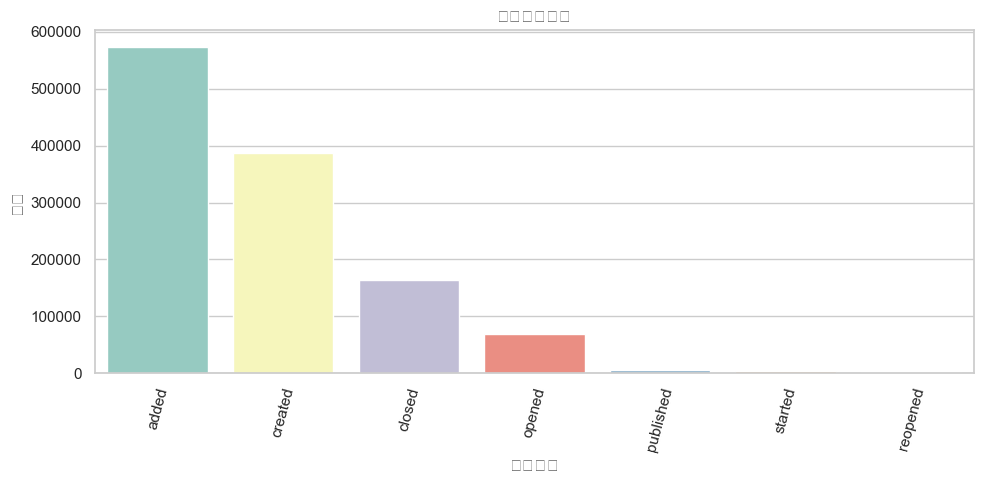

World DataFrame Columns: Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sove

C:\Users\大头\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) Arial.
  ax.figure.canvas.draw_idle()
C:\Users\大头\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) Arial.
  ax.figure.canvas.draw_idle()
C:\Users\大头\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  ax.figure.canvas.draw_idle()
C:\Users\大头\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\plotting.py:95

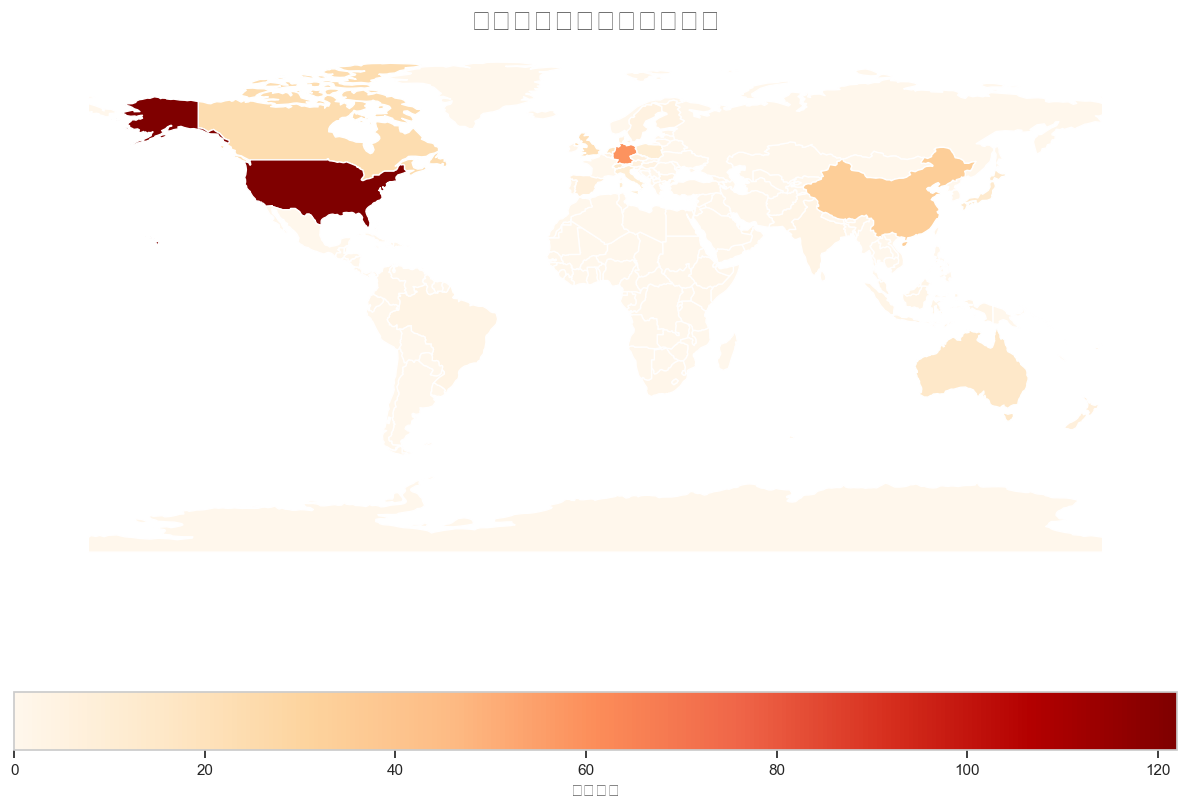

城市热力图已保存为 output_images/city_heatmap.html
图片未找到：output_images/city_heatmap.png


UnicodeEncodeError: 'latin-1' codec can't encode characters in position 51-58: ordinal not in range(256)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timezonefinder import TimezoneFinder
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderServiceError, GeocoderTimedOut
from fpdf import FPDF
import folium
from folium.plugins import HeatMap
import time
import json
import os
import logging
import geopandas as gpd
import pycountry
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

# 配置日志记录
logging.basicConfig(filename='geocoding_errors.log', level=logging.ERROR,
                    format='%(asctime)s %(levelname)s:%(message)s')

# 定义数据文件路径
data_file_path = r"C:\Users\大头\Desktop\users_combined_info_500.csv"

# 定义获取 ISO Alpha-3 代码的函数
def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None

# 读取数据
try:
    data = pd.read_csv(data_file_path)
    print("数据加载成功！")
except FileNotFoundError:
    print(f"未找到文件：{data_file_path}")
    exit()
except Exception as e:
    print(f"读取文件时发生错误：{e}")
    exit()

# 数据预览
print(data.head())
print(data.info())

# 数据清洗
data_clean = data.dropna(subset=['user_id', 'location', 'country', 'event_time'])
print(f"清洗后数据量：{data_clean.shape}")

# 选择前500个唯一用户
user_info = data_clean.drop_duplicates(subset=['user_id']).head(500).copy()
collab_logs = data_clean[data_clean['user_id'].isin(user_info['user_id'])].copy()
print(f"筛选后用户信息数据量：{user_info.shape}")
print(f"筛选后协作日志数据量：{collab_logs.shape}")

# 定义清洗城市名称的函数
def clean_city_name(city):
    # 移除任何非标准字符或模式
    if '⇄' in city:
        return city.split('⇄')[0].strip()
    return city.strip()

# 提取并清洗城市信息
user_info['City'] = user_info['location'].apply(lambda x: x.split(',')[0].strip())
user_info['City'] = user_info['City'].apply(clean_city_name)

# 提取唯一城市列表
unique_cities = user_info['City'].unique()
print(f"唯一城市数量：{len(unique_cities)}")

# 检查是否已有旧的缓存文件并删除
cache_file = 'city_timezone_cache.json'
if os.path.exists(cache_file):
    os.remove(cache_file)
    print("旧的缓存文件已删除。")

# 初始化地理编码器
# 设置合规的 User-Agent
geolocator = Nominatim(user_agent="github_data_analysis_app (2957307229@qq.com)")
tf = TimezoneFinder()

# 初始化或创建新的缓存字典
city_timezone_map = {}

# 定义重试机制
def geocode_city(city, max_retries=3, delay=2):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(city, timeout=10)
            if location:
                timezone = tf.timezone_at(lng=location.longitude, lat=location.latitude)
                if timezone:
                    return {
                        'timezone': timezone,
                        'latitude': location.latitude,
                        'longitude': location.longitude
                    }
                else:
                    return {
                        'timezone': 'Unknown',
                        'latitude': None,
                        'longitude': None
                    }
            else:
                return {
                    'timezone': 'Unknown',
                    'latitude': None,
                    'longitude': None
                }
        except (GeocoderServiceError, GeocoderTimedOut) as e:
            retries += 1
            logging.error(f"获取 {city} 时区时发生错误（尝试 {retries}/{max_retries}）：{e}")
            print(f"获取 {city} 时区时发生错误（尝试 {retries}/{max_retries}）：{e}")
            time.sleep(delay)
    # 如果所有重试都失败，返回未知
    return {
        'timezone': 'Unknown',
        'latitude': None,
        'longitude': None
    }

# 遍历唯一城市并获取时区和地理坐标
for city in unique_cities:
    try:
        data = geocode_city(city)
        city_timezone_map[city] = data
        if data['timezone'] != 'Unknown':
            print(f"{city} 的时区：{data['timezone']}, 纬度：{data['latitude']}, 经度：{data['longitude']}")
        else:
            print(f"无法确定 {city} 的时区或地理位置。")
    except Exception as e:
        city_timezone_map[city] = {
            'timezone': 'Unknown',
            'latitude': None,
            'longitude': None
        }
        logging.error(f"获取 {city} 时区时发生未预料的错误：{e}")
        print(f"获取 {city} 时区时发生未预料的错误：{e}")
    time.sleep(1)  # 遵守Nominatim的使用政策，避免请求过于频繁

# 保存新的缓存
with open(cache_file, 'w', encoding='utf-8') as f:
    json.dump(city_timezone_map, f, ensure_ascii=False, indent=4)
print("已保存城市时区映射到缓存文件。")

# 定义获取时区、纬度和经度的函数（兼容旧缓存格式）
def get_timezone(city):
    data = city_timezone_map.get(city, {})
    if isinstance(data, dict):
        return data.get('timezone', 'Unknown')
    elif isinstance(data, str):
        return data
    else:
        return 'Unknown'

def get_latitude(city):
    data = city_timezone_map.get(city, {})
    if isinstance(data, dict):
        return data.get('latitude', None)
    else:
        return None

def get_longitude(city):
    data = city_timezone_map.get(city, {})
    if isinstance(data, dict):
        return data.get('longitude', None)
    else:
        return None

# 将时区和地理坐标信息映射到用户信息中
user_info['Timezone'] = user_info['City'].apply(get_timezone)
user_info['Latitude'] = user_info['City'].apply(get_latitude).fillna(0)
user_info['Longitude'] = user_info['City'].apply(get_longitude).fillna(0)

# 国家分布
country_counts = user_info['country'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.xticks(rotation=75)
plt.title('用户国家分布')
plt.xlabel('国家')
plt.ylabel('用户数量')
plt.tight_layout()
plt.savefig('output_images/country_distribution.png')  # 保存图片
plt.show()

# 城市分布
city_counts = user_info['City'].value_counts().head(30)
plt.figure(figsize=(14,7))
sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')
plt.xticks(rotation=75)
plt.title('主要城市开发者分布')
plt.xlabel('城市')
plt.ylabel('用户数量')
plt.tight_layout()
plt.savefig('output_images/city_distribution.png')  # 保存图片
plt.show()

# 查看时区分布
timezone_counts = user_info['Timezone'].value_counts()
print(timezone_counts)

# 可视化时区分布
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=timezone_counts.index, y=timezone_counts.values, palette='coolwarm')
plt.xticks(rotation=75)
plt.title('用户时区分布（基于城市映射）')
plt.xlabel('时区')
plt.ylabel('用户数量')
plt.tight_layout()
plt.savefig('output_images/timezone_distribution.png')  # 保存图片
plt.show()

# 提交频率分析
submission_counts = collab_logs['user_id'].value_counts()
plt.figure(figsize=(12,6))
sns.histplot(submission_counts, bins=30, kde=True, color='skyblue')
plt.title('用户提交次数分布')
plt.xlabel('提交次数')
plt.ylabel('用户数量')
plt.tight_layout()
plt.savefig('output_images/submission_frequency.png')  # 保存图片
plt.show()

# 定义高活跃和低活跃的阈值
high_active_threshold = submission_counts.quantile(0.7)
low_active_threshold = submission_counts.quantile(0.3)
high_active_users = submission_counts[submission_counts >= high_active_threshold]
low_active_users = submission_counts[submission_counts <= low_active_threshold]
print(f'高活跃用户数量（提交次数 >= {high_active_threshold}）：{high_active_users.count()}')
print(f'低活跃用户数量（提交次数 <= {low_active_threshold}）：{low_active_users.count()}')

# 活跃时间段分析
collab_logs['event_time'] = pd.to_datetime(collab_logs['event_time'])
merged_data = collab_logs.merge(user_info[['user_id', 'country']], on='user_id', how='left')
merged_data['hour'] = merged_data['event_time'].dt.hour
plt.figure(figsize=(12,6))
sns.histplot(merged_data['hour'], bins=24, kde=True, color='coral')
plt.title('用户活跃时间分布')
plt.xlabel('小时')
plt.ylabel('事件数量')
plt.xticks(range(0,24))
plt.tight_layout()
plt.savefig('output_images/active_time_distribution.png')  
plt.show()

# 事件类型和行为分析
event_type_counts = collab_logs['event_type'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=event_type_counts.index, y=event_type_counts.values, palette='Set2')
plt.xticks(rotation=75)
plt.title('事件类型分布')
plt.xlabel('事件类型')
plt.ylabel('次数')
plt.tight_layout()
plt.savefig('output_images/event_type_distribution.png')  
plt.show()

event_action_counts = collab_logs['event_action'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=event_action_counts.index, y=event_action_counts.values, palette='Set3')
plt.xticks(rotation=75)
plt.title('事件行为分布')
plt.xlabel('事件行为')
plt.ylabel('次数')
plt.tight_layout()
plt.savefig('output_images/event_behavior_distribution.png')
plt.show()

# 生成国家色块地图
# 读取Shapefile
shapefile_path = r"C:\Data\ne_110m_admin_0_countries.shp"  # 请根据实际路径修改
world = gpd.read_file(shapefile_path)

# 查看world数据框的列名和前几行数据
print("World DataFrame Columns:", world.columns)
print(world.head())

# 假设Shapefile中的ISO Alpha-3代码列为 'ISO_A3'
iso_column_shapefile = 'ISO_A3'  # 根据实际情况修改

# 创建国家数量的DataFrame并获取ISO3代码
country_counts_df = country_counts.reset_index()
country_counts_df.columns = ['Country', 'User_Count']
country_counts_df['ISO3'] = country_counts_df['Country'].apply(get_iso3)

# 删除无法找到ISO代码的行
country_counts_df = country_counts_df.dropna(subset=['ISO3'])

# 合并地理数据与用户数量
merged_world = world.merge(country_counts_df, how='left', left_on=iso_column_shapefile, right_on='ISO3')

# 将NaN值替换为0
merged_world['User_Count'] = merged_world['User_Count'].fillna(0)

# 绘制静态色块地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_world.plot(column='User_Count',
                 ax=ax,
                 legend=True,
                 cmap='OrRd',
                 legend_kwds={'label': "用户数量",
                             'orientation': "horizontal"})
plt.title('用户国家分布（色块地图）', fontsize=20)
ax.axis('off')
plt.savefig('output_images/country_choropleth_map.png')  # 保存地图
plt.show()

# 生成城市热力图
# 创建一个基于全球的Folium地图
m = folium.Map(location=[20, 0], zoom_start=2)

# 提取有有效经纬度的城市
heat_data = user_info[user_info['Latitude'] != 0][['Latitude', 'Longitude']].values.tolist()

# 添加热力图
HeatMap(heat_data).add_to(m)

# 保存热力图为HTML文件
heatmap_html = 'output_images/city_heatmap.html'
m.save(heatmap_html)
print(f"城市热力图已保存为 {heatmap_html}")


# 更新PDF报告生成部分
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, '用户数据洞察报告', align='C', ln=True)
        self.ln(10)

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, align='L', ln=True)
        self.ln(5)

    def chapter_body(self, text):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, text)
        self.ln(5)

    def add_image(self, image_path, caption, width=180):
        if os.path.exists(image_path):
            self.set_font('Arial', 'I', 12)
            self.cell(0, 10, caption, align='C', ln=True)
            self.image(image_path, x=15, w=width)
            self.ln(10)
        else:
            print(f"图片未找到：{image_path}")

# 初始化 PDF 报告
pdf = PDFReport()
pdf.set_auto_page_break(auto=True, margin=15)

# 设置标题页
pdf.add_page()
pdf.set_font('Arial', 'B', 20)
pdf.cell(0, 10, '用户数据洞察报告', align='C', ln=True)
pdf.ln(10)
pdf.set_font('Arial', '', 14)
pdf.multi_cell(0, 10, "本报告展示了用户协作行为的分析结果，包括地理分布、时区模式、活跃水平和事件类型。")

# 添加章节：国家分布
pdf.add_page()
pdf.chapter_title("1. 国家分布")
pdf.chapter_body("下图展示了用户在不同国家的分布情况。")
pdf.add_image('output_images/country_distribution.png', "用户国家分布（柱状图）")
pdf.add_image('output_images/country_choropleth_map.png', "用户国家分布（色块地图）")

# 添加章节：城市分布
pdf.chapter_title("2. 城市分布")
pdf.chapter_body("下图展示了用户在主要城市的分布情况。")
pdf.add_image('output_images/city_distribution.png', "主要城市开发者分布（柱状图）")
pdf.add_image('output_images/city_heatmap.png', "用户城市分布（热力图）")

# 添加章节：时区分布
pdf.chapter_title("3. 时区分布")
pdf.chapter_body("下图展示了用户在不同时区的分布情况。")
pdf.add_image('output_images/timezone_distribution.png', "用户时区分布（柱状图）")

# 添加章节：提交频率分析
pdf.add_page()
pdf.chapter_title("4. 提交频率分析")
pdf.chapter_body("下图展示了用户提交次数的分布情况。")
pdf.add_image('output_images/submission_frequency.png', "用户提交次数分布")

# 添加章节：活跃时间段分析
pdf.chapter_title("5. 活跃时间段分析")
pdf.chapter_body("下图展示了用户在一天24小时内的活跃事件数量分布。")
pdf.add_image('output_images/active_time_distribution.png', "用户活跃时间分布")

# 添加章节：事件类型和行为分析
pdf.add_page()
pdf.chapter_title("6. 事件类型和行为分析")
pdf.chapter_body("下图展示了不同事件类型和事件行为的分布情况。")
pdf.add_image('output_images/event_type_distribution.png', "事件类型分布")
pdf.add_image('output_images/event_behavior_distribution.png', "事件行为分布")

# 保存 PDF
output_pdf_path = "User_Data_Insights_Report.pdf"
pdf.output(output_pdf_path)
print(f"PDF报告已生成：{output_pdf_path}")
